# PSB6351_HW1

In [1]:
# Import necessary modules
# glob allows unix style pathname pattern expansion
from glob import glob
# pydicom is the python dicom reader
import pydicom as dicom
import nibabel.nicom.csareader as csareader
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import re

/tmp/ipykernel_63043/3700827553.py:6: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.csareader as csareader


In [2]:
# 5-T1w_MPR_vNav -- MPRAGE structrual dicoms
# 6-fMRI_DistortionMap_PA -- fmri field map dicoms
# 7-fMRI_DistortionMap_AP -- fmri field map dicoms opposite phase encode direction
# 9-fMRI_REVL_ROI_loc_2 -- fmri localizer dicoms run1
# 10-fMRI_REVL_Study_1 -- fmri task dicoms run1
# 14-dMRI_DistortionMap_AP_dMRI_REVL -- dwi field map dicoms
# 16-dMRI_AP_REVL -- diffusion weighted dicoms
my_username = "fzaki001"
# directories will have to be specific to your computer
base_dir = f'/home/{my_username}/Mattfeld_PSB6351'
proj_dir = '/sourcedata'
subj_dir = '/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files'

# with strings I can concatenate them with simple addition lines
data_dir = base_dir + proj_dir + subj_dir

# Here I use glob to grab the dicom files
# Why would I use glob?  What does it give me?
# Answer: globe searches for all files matching the specific pattern provided
# in this case, everything (indexed by *) what's in the data_dir directory
data_files = glob(data_dir + '/*')

assert len(data_files)!=0, "No files listed! Check your directories!"
print(f"Directory listing resulted in {len(data_files)} files")

Directory listing resulted in 355 files


In [3]:
data_files

['/home/fzaki001/Mattfeld_PSB6351/sourcedata/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files/1.3.12.2.1107.5.2.43.166003.30000019061912563618000000017-10-202-8a7elc.dcm',
 '/home/fzaki001/Mattfeld_PSB6351/sourcedata/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files/1.3.12.2.1107.5.2.43.166003.30000019061912563618000000017-10-353-1nxff9y.dcm',
 '/home/fzaki001/Mattfeld_PSB6351/sourcedata/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files/1.3.12.2.1107.5.2.43.166003.30000019061912563618000000017-10-287-8mzh2u.dcm',
 '/home/fzaki001/Mattfeld_PSB6351/sourcedata/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files/1.3.12.2.1107.5.2.43.166003.30000019061912563618000000017-10-196-2eodkg.dcm',
 '/home/fzaki001/Mattfeld_PSB6351/sourcedata/Mattfeld_REVL-000-vCAT-021-S1/scans/10-fMRI_REVL_Study_1/resources/DICOM/files/1.3.12.2.1107.5.2.43.166003.30000019061912563618000000017-10-70-100

In [4]:
# Here I am using the python dicom reader to read in a dicom header
# What should go between the square brackets []
func_vol = dicom.dcmread(data_files[0])

In [5]:
# Elements we're interested in
# Repetition Time
# Echo Time
# Acquisition Matrix 
# Flip Angle
# Acquisition Number
# Protocol Name
# Slice times = data_set[0x00191029].value

print('The number of TRs collected equals: {0}'.format(len(data_files)))
print('The timing of the TR was: {0} ms'.format(func_vol['RepetitionTime'].value))
print('The timing of the TE was: {0} ms'.format(func_vol['EchoTime'].value))
print('The flip angle in degrees was: {0}'.format(func_vol['FlipAngle'].value))
print('The field of view - FOV was: {0}\n'.format(re.sub(r'[A-Za-z\s]', '', func_vol[int('0051100c', 16)].value)))
print(f"The name of the scan was: {func_vol[int('00181030', 16)].value}\n")

# Why use the following format to access information in the header?
# print(data_set[int('0051100c', 16)].value) # data_set[0x0051100c].value
# Allows us to access information that is private in the dicom header.

The number of TRs collected equals: 355
The timing of the TR was: 1760 ms
The timing of the TE was: 35 ms
The flip angle in degrees was: 52
The field of view - FOV was: 1800*1800

The name of the scan was: fMRI_REVL_Study_1



The slice timing was (in ms):
 [1265.     0.   870.    77.5  947.5  157.5 1027.5  237.5 1107.5  315.
 1185.   475.  1345.   552.5 1422.5  632.5 1502.5  710.  1580.   790.
 1660.   395.  1265.     0.   870.    77.5  947.5  157.5 1027.5  237.5
 1107.5  315.  1185.   475.  1345.   552.5 1422.5  632.5 1502.5  710.
 1580.   790.  1660.   395.  1265.     0.   870.    77.5  947.5  157.5
 1027.5  237.5 1107.5  315.  1185.   475.  1345.   552.5 1422.5  632.5
 1502.5  710.  1580.   790.  1660.   395. ]



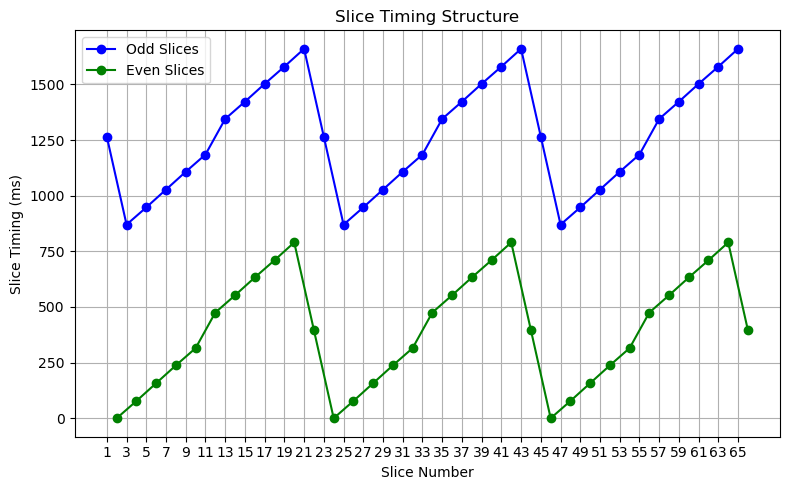

In [6]:
slice_timing = np.round(func_vol[int('00191029', 16)].value, 3)

print('The slice timing was (in ms):\n {0}\n'.format(slice_timing))

n_slices = len(slice_timing)

# get odd and even slice indices
odd_slices = np.arange(0, n_slices, 2)
even_slices = np.arange(1, n_slices, 2)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(odd_slices+1, slice_timing[odd_slices],  'o-', label="Odd Slices", color='blue')
ax.plot(even_slices+1, slice_timing[even_slices], 'o-', label="Even Slices", color='green')

ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle='-')

ax.set_ylabel('Slice Timing (ms)')
ax.set_xlabel('Slice Number')
ax.set_title('Slice Timing Structure')
ax.legend()

plt.xticks(range(1, 67, 2))
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# How do I find phase encoding direction information?
csa_str = func_vol[int('00291010', 16)].value
csa_tr = csareader.read(csa_str)
pe_polarity = csa_tr["tags"]["PhaseEncodingDirectionPositive"]["items"][0]
print('The phase encode direction was: {0} {1} => {2}'.format(func_vol[int('00181312', 16)].value,
                                                        pe_polarity,
                                                        ("PA" if pe_polarity == 1 else ("AP" if pe_polarity == 0 else "Error"))
                                                             ))

The phase encode direction was: COL 0 => AP


COL = AP or PA; ROW = RL or LR\
COL, 1 = PA; COL, 0 = AP (1 = +; 0 = -)

![Phase encode direction](https://ars.els-cdn.com/content/image/1-s2.0-S2213158216300638-gr2.jpg)

[Kennis et al., 2016](https://doi.org/10.1016/j.nicl.2016.03.022)
